In [1]:
import torch

from sbi.analysis.plot import marginal_plot, pairplot

## Plotting functionality

Here we will have a look at the different options for finetuning `pairplots` and `marginal_plots`.

Lets first draw some samples from the posterior used in a tutorial 7.


In [2]:
from toy_posterior_for_07_cc import ExamplePosterior

posterior = ExamplePosterior()
posterior_samples = posterior.sample((100,))


We will start with the default plot and gradually make it prettier

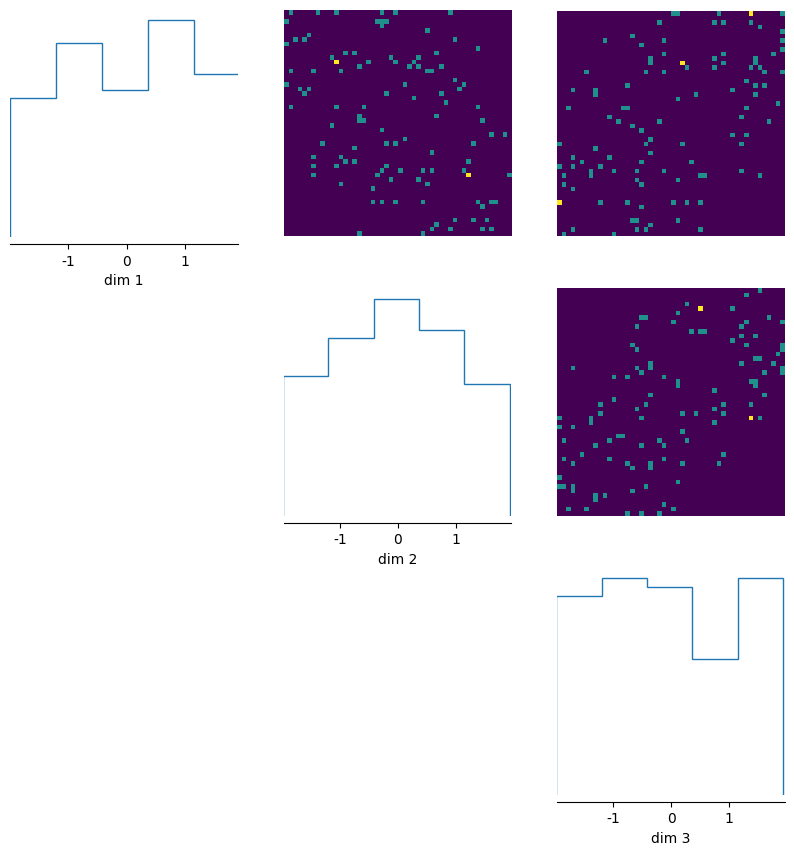

In [3]:
_ = pairplot(
    posterior_samples,
)

### Customisation

The pairplots are split into three regions, the diagonal (`diag`) and the upper and lower off-diagonal regions(`upper` and `lower`). We can pass seperate arguments (e.g. `hist`, `kde`, `scatter`) for each region, as well as corresponding style keywords in a dictionary (by using e.g. `upper_kwargs`). For overall figure stylisation one can use `fig_kwargs`.

To get a closer look at the potential options, have a look at the `_get_default_fig_kwargs`, `_get_default_diag_kwargs` and `_get_default_offdiag_kwargs` functions in [analysis/plot.py](https://github.com/sbi-dev/sbi/blob/961-pairplot/sbi/analysis/plot.py).

As illustrated below, we can directly use any `matplotlib` keywords (such as `cmap` for images) by passing them in the `mpl_kwargs` entry of `upper_kwargs` or `diag_kwargs`.


Lets now make a scatter plot for the upper diagonal, a histogram for the diagonal, and pass keyword dictionaries for both.

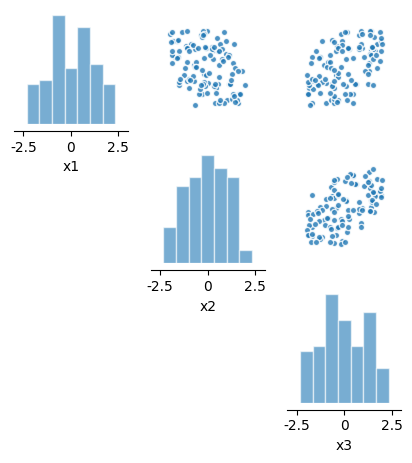

In [4]:
_ = pairplot(
    posterior_samples, limits=[[-3,3]*3], figsize=(5, 5),
    diag="hist",
    upper="scatter",
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True}},
    upper_kwargs={"mpl_kwargs": {"color":'tab:blue',
                                 "s":20,
                                 "alpha":.8}},
    labels=["x1", "x2", "x3"],
)

### Compare two sets of samples

By passing a list of sets of samples, we can plot two sets of samples on top of each other.

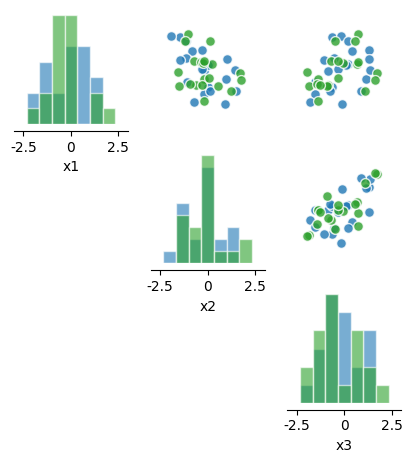

In [5]:
# draw two different subsets of samples to plot
posterior_samples1 = posterior.sample((20,))
posterior_samples2 = posterior.sample((20,))

_ = pairplot(
    [posterior_samples1,posterior_samples2], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist","hist"],
    upper=["scatter","scatter"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True}},
    upper_kwargs={"mpl_kwargs": {"s":50,
                                 "alpha":.8}},
    labels=["x1", "x2", "x3"],
)

### Multi-layered plots

We can use the same functionality to make a multi-layered plot using the same set of samples, e.g. a kernel-density estimate on top of scatter plot.

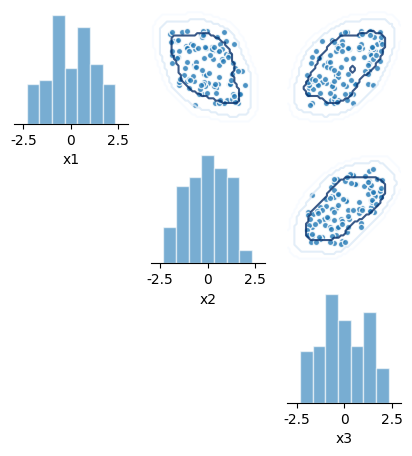

In [6]:
_ = pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist",None],
    upper=["scatter","contour"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',
                                  "s":20,
                                  "alpha":.8},},
                  {"mpl_kwargs": {"cmap":'Blues_r',
                                  "alpha":.8,
                                  "colors":None}}],
    labels=["x1", "x2", "x3"],
            fig_kwargs={"despine":{"offset":0}}
)

### Lower diagonal

We can add something in the lower off-diagonal as well.

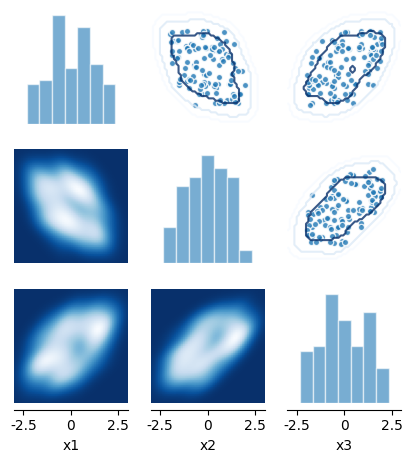

In [7]:
_ = pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist",None],
    upper=["scatter","contour"],
    lower =["kde",None],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True}},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',
                                  "s":20,
                                  "alpha":.8}},
                  {"mpl_kwargs": {"cmap":'Blues_r',
                                  "alpha":.8,
                                  "colors":None}}],
    lower_kwargs={"mpl_kwargs": {"cmap":"Blues_r"}},
    labels=["x1", "x2", "x3"],
)

### Adding observed data

We can also add points, e.g., our observed data `x_o` to the plot.

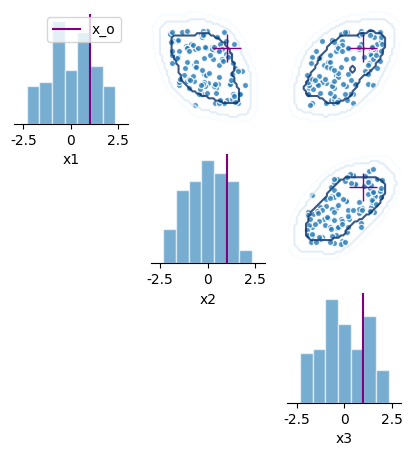

In [8]:
# fake observed data:
x_o = torch.ones(1,3)

_ = pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    diag=["hist",None],
    upper=["scatter","contour"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True}},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',
                                  "s":20,
                                  "alpha":.8}},
                  {"mpl_kwargs": {"cmap":'Blues_r',
                                  "alpha":.8,
                                  "colors":None}}],
    labels=["x1", "x2", "x3"],
    points = x_o,
    fig_kwargs={"points_labels": ["x_o"],
                "legend":True,
                "points_colors":["purple"],
                "points_offdiag" : {"marker":"+", "markersize":20},
                "despine":{"offset":0}},
)

### Subsetting the plot

For high-dimensional posteriors, we might only want to visualise a subset, this can by passing a list of entries to plot to the `subset` argument of the `pairplot` function.

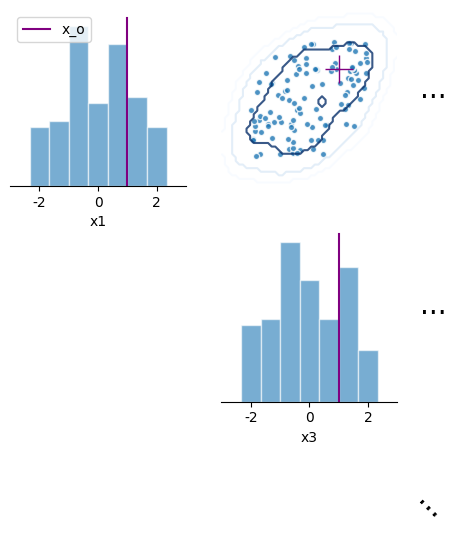

In [9]:
_ = pairplot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3], figsize=(5, 5),
    subset=[0,2],
    diag=["hist",None],
    upper=["scatter","contour"],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True}},
    upper_kwargs=[{"mpl_kwargs": {"color":'tab:blue',
                                  "s":20,
                                  "alpha":.8}},
                  {"mpl_kwargs": {"cmap":'Blues_r',
                                  "alpha":.8,
                                  "colors":None}}],
    labels=["x1", "x2", "x3"],
    points = x_o,
    fig_kwargs={"points_labels": ["x_o"],
                "legend":True,
                "points_colors":["purple"],
                "points_offdiag" : {"marker":"+", "markersize":20},
                "despine":{"offset":0}},
)

### Plot just the marginals

1D Marginals can also be visualised using the `marginal_plot` function

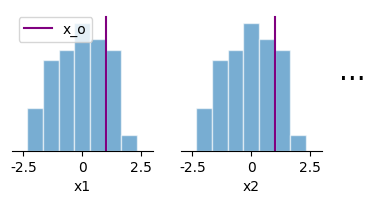

In [10]:
# plot posterior samples
_ = marginal_plot(
    [posterior_samples,posterior_samples], limits=[[-3,3]*3],
    subset=[0,1],
    diag=["hist",None],
    diag_kwargs={"mpl_kwargs":{"bins":10,
                                "color":'tab:blue',
                                "edgecolor":'white',
                                "linewidth":1,
                                "alpha":0.6,
                                "histtype":"bar",
                                "fill":True},},
    labels=["x1", "x2", "x3"],
    points = [torch.ones(1, 3)],
    figsize=(4, 2),
    fig_kwargs={"points_labels": ["x_o"],
                "legend":True,
                "points_colors":["purple"],
                "points_offdiag" : {"marker":"+", "markersize":20},
                "despine":{"offset":0}},
)